<a href="https://colab.research.google.com/github/looee1q/PracticalML/blob/10-errors-random-forest/Ensembles_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозируем задержки самолётов


В этом домашнем задании вы будете работать с задачей про задержки самолётов.  На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.

## Импорт библиотек, установка констант

In [9]:
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import StandardScaler

In [3]:
RANDOM_STATE = 111
DATASET_PATH = 'https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/flight_delays_train.csv'

## Загрузка и обзор данных

In [104]:
data = pd.read_csv(DATASET_PATH)

In [105]:
data.head(6)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y
5,c-8,c-3,c-4,1918,NW,MEM,MCO,683,N


## Вопрос для Quiz

Сколько числовых столбцов в данных?

In [7]:
data.describe().shape

(8, 2)

In [8]:
data.shape

(100000, 9)

## Обучение моделей

Разбейте данные
* на матрицу объект признак `X`, содержащую только числовые столбцы `DepTime`, `Distance`
* вектор с целевой переменной `y`, равный столбцу `dep_delayed_15min`, переведенном в 0 и 1 по правилу: 'Y' - 1, 'N' - 0.

In [106]:
X = data.loc[:, data.describe().columns].copy()
y = data.dep_delayed_15min.replace({'Y' : 1, 'N' : 0})

<ipython-input-106-8f448a0a4070>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = data.dep_delayed_15min.replace({'Y' : 1, 'N' : 0})


Обучите по кросс-валидации с тремя фолдами и метрикой *ROC-AUC* (`scoring='roc_auc'`) три модели с гиперпараметрами по умолчанию:
* решающее дерево
* случайный лес
* градиентный бустинг

Выведите на экран среднее качество по кросс-валидации каждой из моделей.

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [108]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X = pd.DataFrame(scaler.transform(X), columns=X.columns)

In [35]:
decision_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
random_forest = RandomForestClassifier(random_state=RANDOM_STATE)
gradient_boosting = GradientBoostingClassifier(random_state=RANDOM_STATE)

In [36]:
scoring = "roc_auc"
decision_tree_scoring = cross_val_score(decision_tree, X, y, cv = 3, scoring=scoring)
random_forest_scoring = cross_val_score(random_forest, X, y, cv = 3, scoring=scoring)
gradient_boosting_scoring = cross_val_score(gradient_boosting, X, y, cv = 3, scoring=scoring)

In [37]:
decision_tree_scoring.mean()

np.float64(0.5792982351791407)

In [38]:
random_forest_scoring.mean()

np.float64(0.6758129274941099)

In [40]:
gradient_boosting_scoring.mean()

np.float64(0.6992516986788738)

## Вопрос для Quiz

какой алгоритм показал наилучшее качество?

Выведите *bias* и *variance* каждой из моделей при помощи `bias_variance_decomp` из библиотеки `mlxtend`. Функция на вход ожидает получения тренировочных и тестовых данных, поэтому разобъем все данные на train и test.

Для ускорения вычислений
* возьмите только первые 1000 строк из тренировочных данных (`Xtrain[:1000], ytrain[:1000]`)
* поставьте `num_rounds = 50` в функции `bias_variance_decomp`

И не забудьте перевести `pd.dataframe` в `np.array` - так как библиотека умеет работать только с этим типом данных (`Xtrain.values` и так для всех объектов).

In [41]:
!pip install mlxtend --upgrade

In [42]:
from mlxtend.evaluate import bias_variance_decomp

In [59]:
bias_variance_decomp(decision_tree, X_train[:1000].values, y_train[:1000].values, X_test.values, y_test.values, loss='mse', num_rounds=50, random_seed=RANDOM_STATE)

(np.float64(0.2999584),
 np.float64(0.181846976),
 np.float64(0.11811142400000005))

In [60]:
bias_variance_decomp(random_forest, X_train[:1000].values, y_train[:1000].values, X_test.values, y_test.values, loss='mse', num_rounds=50, random_seed=RANDOM_STATE)

(np.float64(0.24638400000000002),
 np.float64(0.185165056),
 np.float64(0.06121894400000002))

In [61]:
bias_variance_decomp(gradient_boosting, X_train[:1000].values, y_train[:1000].values, X_test.values, y_test.values, loss='mse', num_rounds=50, random_seed=RANDOM_STATE)

(np.float64(0.2181672),
 np.float64(0.17135316799999997),
 np.float64(0.046814032000000026))

## Вопрос для Quiz

какой алгоритм с гиперпараметрами по умолчанию имеет наименьшее смещение?

## Подбор гиперпараметров

Напомним, как мы действуем при подборе гиперпараметров:
* разбиваем данные на *train* и *test*
* на train по кросс-валидации при помощи `GridSearchCV` ищем наилучшие гиперпараметры модели
* оцениваем качество модели с наилучшими гиперпараметрами на *test*

Будем использовать 3 фолда при кросс-валидации, а метрику - *ROC-AUC* (`scoring='roc_auc'`).


Далее везде можно обучать модель на первых 10000 строк из обучающей выборки (так как всего два признака).

### 1. Подберите гиперпараметры для решающего дерева:
* `max_depth` (обязательно)
* `max_features` (обязательно)
* `criterion` (по желанию)
* `min_samples_split` (по желанию)
* `min_samples_leaf` (по желанию)

Диапазоны поиска гиперпараметров выбирайте самостоятельно.

Добейтесь качества *ROC-AUC* $>0.65$ на кросс-валидации.

In [71]:
decision_tree_params = {'max_depth': np.arange(2, 20 + 1, 1), "max_features": np.arange(1, X.columns.size + 1, 1), "criterion" : ("gini", "entropy", "log_loss")}
decision_tree_gs = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE), param_grid=decision_tree_params, cv = 3, scoring='roc_auc')
decision_tree_gs.fit(X_train[:10000], y_train[:10000])

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=111),
             param_grid={'criterion': ('gini', 'entropy', 'log_loss'),
                         'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20]),
                         'max_features': array([1, 2])},
             scoring='roc_auc')

In [72]:
print(f'best estimator: {decision_tree_gs.best_estimator_}')
print(f'best score: {decision_tree_gs.best_score_}')

best estimator: DecisionTreeClassifier(criterion='entropy', max_depth=np.int64(4),
                       max_features=np.int64(2), random_state=111)
best score: 0.6928192970854005


Теперь обучите на **всех** тренировочных данных решающее дерево с лучшими  
найденными гиперпараметрами и выведите *ROC-AUC* на тесте.

In [109]:
decision_tree_best = DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=2, random_state=RANDOM_STATE)
decision_tree_best.fit(X_train, y_train)
y_decision_tree_best_pred = decision_tree_best.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_decision_tree_best_pred)

np.float64(0.6956885102638536)

### 2. Подберите гиперпараметры для случайного леса:
* `n_estimators` (обязательно)
* `max_depth` (обязательно)
* `max_features` (по желанию)
* `criterion` (по желанию)
* `min_samples_split` (по желанию)
* `min_samples_leaf` (по желанию)

Диапазоны поиска гиперпараметров выбирайте самостоятельно.

Добейтесь качества *ROC-AUC* $>0.65$ на кросс-валидации.

In [76]:
random_forest_params = {"n_estimators": np.arange(20, 200 + 20, 20), 'max_depth': np.arange(2, 20 + 1, 1)}
random_forest_gs = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE), param_grid=random_forest_params, cv = 3, scoring='roc_auc')
random_forest_gs.fit(X_train[:10000], y_train[:10000])

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=111),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20]),
                         'n_estimators': array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200])},
             scoring='roc_auc')

Теперь обучите на **всех** тренировочных данных случайный лес с лучшими  
найденными гиперпараметрами и выведите *ROC-AUC* на тесте.

In [77]:
print(f'best estimator: {random_forest_gs.best_estimator_}')
print(f'best score: {random_forest_gs.best_score_}')

best estimator: RandomForestClassifier(max_depth=np.int64(5), n_estimators=np.int64(200),
                       random_state=111)
best score: 0.6990186886846569


In [110]:
random_forest_best = random_forest_gs.best_estimator_
random_forest_best.fit(X_train, y_train)
y_random_forest_best_pred = random_forest_best.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_random_forest_best_pred)

np.float64(0.7034733904588185)

### 3. Подберите гиперпараметры для градиентного бустинга:
* `n_estimators` (обязательно)
* `max_depth` (обязательно)
* `max_features` (по желанию)
* `criterion` (по желанию)
* `min_samples_split` (по желанию)
* `min_samples_leaf` (по желанию)

Диапазоны поиска гиперпараметров выбирайте самостоятельно.

Добейтесь качества *ROC-AUC* $>0.65$ на кросс-валидации.

In [79]:
gradient_boosting_params = {"n_estimators": np.arange(20, 200 + 20, 20), 'max_depth': np.arange(2, 20 + 1, 1)}
gradient_boosting_gs = GridSearchCV(GradientBoostingClassifier(random_state=RANDOM_STATE), param_grid=gradient_boosting_params, cv = 3, scoring='roc_auc')
gradient_boosting_gs.fit(X_train[:10000], y_train[:10000])

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=111),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20]),
                         'n_estimators': array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200])},
             scoring='roc_auc')

In [80]:
print(f'best estimator: {gradient_boosting_gs.best_estimator_}')
print(f'best score: {gradient_boosting_gs.best_score_}')

best estimator: GradientBoostingClassifier(max_depth=np.int64(2), n_estimators=np.int64(40),
                           random_state=111)
best score: 0.6994285103745299


Теперь обучите на **всех** тренировочных данных градиентный бустинг с лучшими  
найденными гиперпараметрами и выведите *ROC-AUC* на тесте.

In [111]:
gradient_boosting_best = GradientBoostingClassifier(random_state=RANDOM_STATE, max_depth=2, n_estimators=40)
gradient_boosting_best.fit(X_train, y_train)
y_gradient_boosting_best_pred = gradient_boosting_best.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_gradient_boosting_best_pred)

np.float64(0.7005797913406246)

Теперь поставьте `learning_rate = 0.01` (в десять раз меньше, чем по умолчанию) и увеличьте найденное число деревьев в 10 раз.

С этими изменениями обучите бустинг на трейне и выведите качество на тесте.

In [83]:
gradient_boosting_best_2 = GradientBoostingClassifier(random_state=RANDOM_STATE, max_depth=2, n_estimators=400, learning_rate=0.01)
gradient_boosting_best_2.fit(X_train, y_train)
y_gradient_boosting_best_2_pred = gradient_boosting_best_2.predict(X_test)
roc_auc_score(y_test, y_gradient_boosting_best_2_pred)

np.float64(0.5025199730975844)

## Вопрос для Quiz

Есть ли алгоритм, который на тестовых данных показывает качество, значительно превышающее результаты других алгоритмов? (более чем на 0.1 десятую)

## Вопрос для Quiz

Чему равно качество на тестовых данных у наилучшей модели? Ответ округлите до десятых.

## Размышления

Мы использовали для обучения очень много объектов и очень мало признаков, поэтому ансамбли моделей не смогли себя показать в полную мощь. Если задействовать больше характеристик полета, то и качество моделей может стать выше.

# Улучшение модели

Мы выкинули очень много колонок из начальной таблицы, но, возможно, они полезны для наших моделей.

Попробуем улучшить модель, использовав другие признаки.

In [112]:
data['dep_delayed_15min'] = data['dep_delayed_15min'].map({'Y' : 1, 'N' : 0})

Обработаем колонку месяц, оставив в ней только число - номер месяца.

Посмотрим на среднее количество задержек в каждом месяце.

In [113]:
data['Month'] = data['Month'].apply(lambda x: int(x.split('-')[1]))

print('average:', data['dep_delayed_15min'].mean())

data.groupby('Month')['dep_delayed_15min'].mean()

average: 0.19044


,dep_delayed_15min
Month,
1,0.190588
2,0.177406
3,0.194997
4,0.155328
5,0.153693
6,0.221892
7,0.238112
8,0.201925
9,0.156683


Мы видим, что в некоторые месяцы (7 и 12) задержек довольно много, а в какие-то месяцы наоборот меньше. Так что признак может пригодиться!

В данных также есть интересный признак `UniqueCarrier` - это код авиакомпании-перевозчика.

Давайте посмотрим, связаны ли как-то задержки самолетов с авиакомпанией. Для этого выведем среднее число задержек и количество рейсов по каждой авиакомпании.

In [114]:
print('average:', data['dep_delayed_15min'].mean())

data.groupby('UniqueCarrier').agg({"dep_delayed_15min": ["mean", "count"]})

average: 0.19044


dep_delayed_15min       
                           mean  count
UniqueCarrier                         
AA                     0.187938   9418
AQ                     0.076923    234
AS                     0.243474   2222
B6                     0.213819   1838
CO                     0.181818   4334
DH                     0.161491    966
DL                     0.168922   8128
EV                     0.275318   3930
F9                     0.155070   1006
FL                     0.242185   3039
HA                     0.043307    762
HP                     0.142235   1378
MQ                     0.194545   7443
NW                     0.167890   6403
OH                     0.175882   4594
OO                     0.172801   7390
TZ                     0.143498    446
UA                     0.192263   6876
US                     0.167387   6482
WN                     0.213433  15082
XE                     0.173869   5901
YV                     0.224624   2128

Мы видим, что некоторые перевозчики довольно часто задерживают рейсы, а некоторые почти не задерживают. То есть знание об авиакомпании важно!


Код авиакомпании - это категориальный признак. В начале курса мы немного говорили про то, как можно кодировать такие признаки - вот [ссылка на соответствующий урок](https://stepik.org/lesson/806464/step/4?unit=809640).

Подход называется OneHot encoding. Напомним, в чем он состоит:
* мы создаем столько же колонок, сколько различных категорий в столбце
* далее для объекта ставим 1 в ту колонку, к категории которой он относится, а во все остальные колонки ставим 0

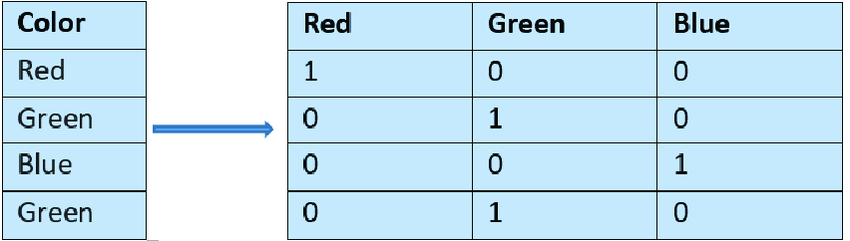

Заметим, что сумма значений в каждой строке равна 1 - то есть получили линейно-зависимые столбцы. Поэтому на практике создают на 1 колонку меньше, чем планировалось, чтобы избежать линейной зависимости.

Закодируем столбец `UniqueCarrier` при помощи OneHot encoding. В pandas этот метод называется get_dummies.

In [115]:
from sklearn.preprocessing import MinMaxScaler

X = data[['Month','UniqueCarrier','DepTime','Distance']]
y = data['dep_delayed_15min']

X = pd.get_dummies(X, columns=['UniqueCarrier'], drop_first=True, dtype=int) # drop_first=True - выкидываем один столбец, чтобы избежать линейной зависимости
X = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)
X.head()

,Month,DepTime,Distance,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,UniqueCarrier_CO,UniqueCarrier_DH,UniqueCarrier_DL,UniqueCarrier_EV,...,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_TZ,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV
0,0.636364,0.763127,0.142336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.272727,0.610738,0.163017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.727273,0.560995,0.078264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.909091,0.400316,0.170722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.818182,0.721279,0.079684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [116]:
print('Decision Tree:', cross_val_score(DecisionTreeClassifier(random_state=RANDOM_STATE), X, y, cv=3, scoring='roc_auc').mean())
print('Random Forest:', cross_val_score(RandomForestClassifier(random_state=RANDOM_STATE), X, y, cv=3, scoring='roc_auc').mean())
print('Gradient Boosting:', cross_val_score(GradientBoostingClassifier(random_state=RANDOM_STATE), X, y, cv=3, scoring='roc_auc').mean())

Decision Tree: 0.5809076341383452
Random Forest: 0.6944039152557787
Gradient Boosting: 0.7129769434900485


Базовые модели показывают результаты по кросс-валидации чуть лучше! Ура!

Теперь вам необходимо подобрать оптимальные гиперпараметры модели так же, как вы делали в заданиях выше.

Так как информации о каждой авиакомпании не так много, то здесь для обучения лучше использовать все тренировочные данные, а не только первые 10000 строк.

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

### Подберите оптимальные гиперпараметры для Decision Tree.

In [94]:
decision_tree_2_params = {'max_depth': np.arange(2, 15 + 1, 1), "max_features": np.arange(1, X_train.columns.size + 1, 1), "criterion" : ("gini", "entropy", "log_loss")}
decision_tree_2_gs = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE), param_grid=decision_tree_2_params, cv = 3, scoring='roc_auc')
decision_tree_2_gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=111),
             param_grid={'criterion': ('gini', 'entropy', 'log_loss'),
                         'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                         'max_features': array([1, 2])},
             scoring='roc_auc')

In [95]:
print(f'best estimator: {decision_tree_2_gs.best_estimator_}')
print(f'best score: {decision_tree_2_gs.best_score_}')

best estimator: DecisionTreeClassifier(max_depth=np.int64(5), max_features=np.int64(2),
                       random_state=111)
best score: 0.6933055824235751


In [96]:
decision_tree_2_best = decision_tree_2_gs.best_estimator_
decision_tree_2_best.fit(X_train, y_train)
y_decision_tree_2_best_pred = decision_tree_2_best.predict(X_test)
roc_auc_score(y_test, y_decision_tree_2_best_pred)

np.float64(0.5367317909947196)

Теперь обучите на **всех** тренировочных данных случайный лес с лучшими  
найденными гиперпараметрами и выведите *ROC-AUC* на тесте.

In [103]:
random_forest_best_2 = RandomForestClassifier(max_depth=5, n_estimators=200, random_state=RANDOM_STATE)
random_forest_best_2.fit(X_train, y_train)
y_random_forest_best_2_pred = random_forest_best_2.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_random_forest_best_2_pred)

np.float64(0.7034733904588185)

### Подберите оптимальные гиперпараметры для Random Forest.

In [ ]:
# your code here

Теперь обучите на **всех** тренировочных данных случайный лес с лучшими  
найденными гиперпараметрами и выведите *ROC-AUC* на тесте.

In [ ]:
# your code here

### Подберите оптимальные гиперпараметры для Random Forest.

Чтобы сверить часы с составителями задания, подберите оптимальные гиперпараметры бустинга:
* задайте n_estimators = 70
* ищите max_depth в диапазоне от 10 до 20 не включительно с шагом 3

In [98]:
gradient_boosting_params_3 = {'max_depth': np.arange(10, 20, 3)}
gradient_boosting_gs_3 = GridSearchCV(GradientBoostingClassifier(random_state=RANDOM_STATE, n_estimators=70), param_grid=gradient_boosting_params_3, cv = 3, scoring='roc_auc')
gradient_boosting_gs_3.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(n_estimators=70,
                                                  random_state=111),
             param_grid={'max_depth': array([10, 13, 16, 19])},
             scoring='roc_auc')

In [99]:
print(f'best estimator: {gradient_boosting_gs_3.best_estimator_}')
print(f'best score: {gradient_boosting_gs_3.best_score_}')

best estimator: GradientBoostingClassifier(max_depth=np.int64(10), n_estimators=70,
                           random_state=111)
best score: 0.6906745989142161


Теперь обучите на **всех** тренировочных данных градиентный бустинг с лучшими  
найденными гиперпараметрами и выведите *ROC-AUC* на тесте.

In [121]:
gradient_boosting_best_3 = gradient_boosting_gs_3.best_estimator_
gradient_boosting_best_3.fit(X_train, y_train)
y_gradient_boosting_best_pred_3 = gradient_boosting_best_3.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_gradient_boosting_best_pred_3)

np.float64(0.7244302758864769)

## Вопрос для Quiz

Чему равно качество модели с наилучшими параметрами, обученной на всех тренировочных данных и примененной к тесту?

Ответ округлите до десятых.

Посмотрим на важность признаков у полученного бустинга.

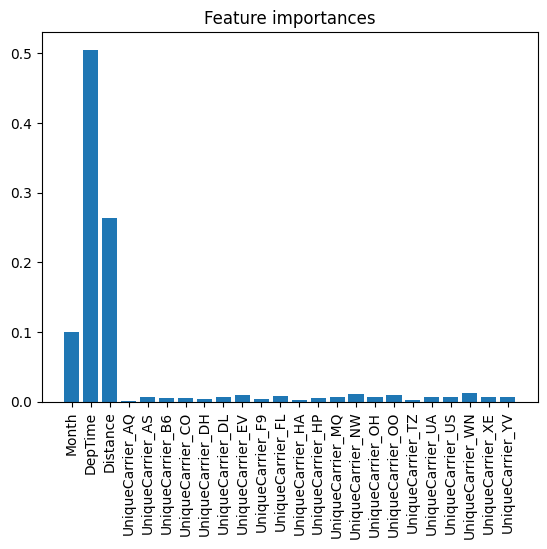

In [122]:
import matplotlib.pyplot as plt

# в коде model - это модель (если назвали по-другому, то в этом кусочке измените model на свое название)
model = gradient_boosting_gs_3.best_estimator_
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure()
plt.title("Feature importances")
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.xticks(range(len(model.feature_importances_)), X.columns, rotation='vertical')
plt.show()

## Вопрос для Quiz

Какой признак оказался самым важным для градиентного бустинга?

# Бонус

Мы вcе еще не используем очень много колонок из таблицы.

Попробуйте преобразовать какие-нибудь из оставшихся колонок в числовые признаки и с их добавлением в данные обучить модели.

Попытайтесь добиться как можно более высокого качества. Любые эксперименты приветствуются!

In [ ]:
# your code here